In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from os import path
import sys
sys.path.append(path.join(".."))

import saly
import saly.backend as S
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

EPOCHS = 25
SPECIES = 'Mouse'
DATA_PATH = '/home/mlongar/Data/SingleCellGeneExpression/'
DATASET_HRVATIN_PATH = DATA_PATH + 'hrvatin_2018.h5ad' 
DATASET_CHEN_PATH = DATA_PATH + 'chen_2017.h5ad'
DATASET_BIG_PATH = DATA_PATH + '10x_mouse_1.3mln.h5ad'
MARKER_PATH = DATA_PATH + 'panglao_gene_markers.tab.gz'

Using TensorFlow backend.


In [2]:
hrvatin_data = saly.load_h5ad(DATASET_HRVATIN_PATH)
print("HRVATIN DATA\n", hrvatin_data.shape)

HRVATIN DATA
 (48266, 25186)


In [3]:
chen_data = saly.load_h5ad(DATASET_CHEN_PATH)
print("CHEN DATA\n", chen_data.shape)

CHEN DATA
 (14437, 23284)


In [4]:
big_data = saly.load_h5ad(DATASET_BIG_PATH)
print("BIG DATA\n", big_data.shape)

BIG DATA
 (1306127, 27932)


In [5]:
chen_data = saly.drop_rows(chen_data, ['tanycyte', 'unknown', 'ependymal cell', 'epithelial cell'])

Dropped 4750 cell(s). New shape: (9687, 23284)


In [6]:
markers_db = saly.load_markers(MARKER_PATH, SPECIES)
markers = saly.get_mutual_markers([hrvatin_data, chen_data, big_data], markers_db)
print('Mutual markers:', len(markers))

Mutual markers: 7382


In [7]:
marker_aliases = {'Neuron' : 'Neurons',
                'Oligodendrocyte' : 'Oligodendrocytes',
                'Muscle cell' : 'Smooth muscle cells',
                'Endothelial cell' : 'Endothelial cells',
                'Astrocyte' : 'Astrocytes',
                'Macrophage' : 'Macrophages',
                'OPC' : 'Oligodendrocyte progenitor cells',
                'Pericyte' : 'Pericytes'}

saly.check_labels([hrvatin_data, chen_data], markers, marker_aliases)

In [8]:
hrvatin_data = saly.drop_unused_genes(hrvatin_data, markers)
chen_data = saly.drop_unused_genes(chen_data, markers)
big_data = saly.drop_unused_genes(big_data, markers)

saly.check_shape([hrvatin_data, chen_data, big_data])

Dropped 21107 gene(s). New shape: (48266, 4079)
Dropped 19205 gene(s). New shape: (9687, 4079)
Dropped 23853 gene(s). New shape: (1306127, 4079)


In [9]:
big_data = saly.mark_as_unlabelled(big_data.copy())

In [10]:
train_data, _, _ = saly.preprocess_data(big_data, splits=10,
                                       train=1, test=0, validation=0)

In [11]:
chen_data = S.normalize_data(chen_data.copy())
hrvatin_data = S.normalize_data(hrvatin_data.copy())

In [16]:
model, marker_model, encoder_model = saly.build_model(train_data, markers, supervised=False);

In [17]:
history = saly.train_model(model, train_data, markers, marker_aliases,
                           5, validation_data=chen_data, verbose=1);

Train on 1306127 samples, validate on 9687 samples
Epoch 1/5
1306127/1306127 [==============================] - 83s 64us/step - loss: 2266.3686 - cell_activations_loss: 0.0000e+00 - output_loss: 2.2664 - cell_activations_marker_prediction_metric: 0.0000e+00 - val_loss: 3030.9518 - val_cell_activations_loss: 0.0000e+00 - val_output_loss: 3.0310 - val_cell_activations_marker_prediction_metric: 0.7438
Epoch 2/5
1306127/1306127 [==============================] - 83s 63us/step - loss: 2081.8199 - cell_activations_loss: 0.0000e+00 - output_loss: 2.0818 - cell_activations_marker_prediction_metric: 0.0000e+00 - val_loss: 2991.6951 - val_cell_activations_loss: 0.0000e+00 - val_output_loss: 2.9917 - val_cell_activations_marker_prediction_metric: 0.7016
Epoch 3/5
1306127/1306127 [==============================] - 82s 63us/step - loss: 2061.0901 - cell_activations_loss: 0.0000e+00 - output_loss: 2.0611 - cell_activations_marker_prediction_metric: 0.0000e+00 - val_loss: 2949.4890 - val_cell_activat

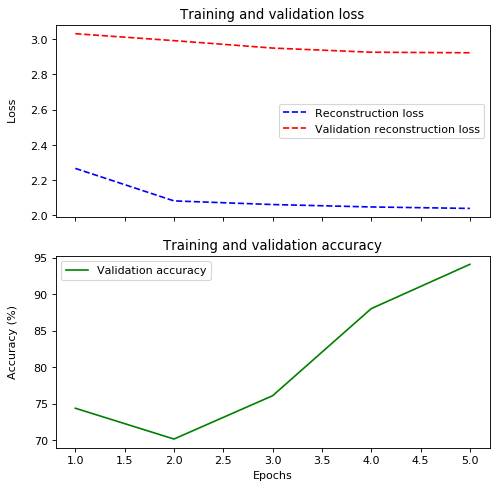

In [18]:
saly.plot_model_history(history, supervised=False, labelled_training=False)

In [19]:
saly.test_model(model, hrvatin_data, markers, marker_aliases)

Test reconstruction loss: 3.07414337
Test prediction accuracy: 88.105 %


[3074.143364553618, 0.0, 3.0741433661709086, 0.8810549869498033]

In [21]:
from sklearn.manifold import TSNE
tsne = TSNE()
colours = S.load_label_colours('../Notebooks/Data/hrvatin_chen_label_colours.pickle')

In [22]:
chen_cell_activations = marker_model.predict(chen_data.X)
chen_bottleneck_activations = encoder_model.predict(chen_data.X)

In [26]:
saly.get_results(chen_data.obs['labels'], chen_cell_activations, markers, marker_aliases)

Correct predictions: 9115 out of 9687 (94.1%)


In [27]:
hrvatin_cell_activations = marker_model.predict(hrvatin_data.X)
hrvatin_bottleneck_activations = encoder_model.predict(hrvatin_data.X)

In [28]:
saly.get_results(hrvatin_data.obs['labels'], hrvatin_cell_activations, markers, marker_aliases)

Correct predictions: 42525 out of 48266 (88.11%)
